# 내 집을 마련하고 싶어요!

In [140]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.options.mode.chained_assignment = None

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict ,train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor

from IPython.core import display as ICD

## 1. 데이터 살펴보기(EDA)
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 데이터 불러오기

In [141]:
dir_path = os.getenv("HOME") + '/aiffel/kaggle_kakr_housing/data'
train_data_path = os.path.join(dir_path, 'train.csv')
test_data_path = os.path.join(dir_path, 'test.csv')

df_train = pd.read_csv(train_data_path)              # csv파일 불러오기(Train data)
df_test = pd.read_csv(test_data_path)                # csv파일 불러오기(Test data)

### 데이터 확인
Train과 Test의 차이는 프로젝트의 목적인 **Price**열의 유무이다.

In [142]:
for title, df in zip(['\nTrain Dataset', '\nTest Dataset'], [df_train, df_test]):
    print(title)
    ICD.display(df.head()) # 한 cell에 2개 이상의 dataframe 출력하기


Train Dataset


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711



Test Dataset


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 데이터 및 feature의 개수

In [143]:
print('Shape of Train data : ', df_train.shape)
print('Shape of Test data : ', df_test.shape)

Shape of Train data :  (15035, 21)
Shape of Test data :  (6468, 20)


### Feature 종류

In [144]:
print('Feature of Train dataset')
print((df_train.columns))
print('*'*80)
print('Feature of Test dataset')
print((df_test.columns))

Feature of Train dataset
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
********************************************************************************
Feature of Test dataset
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


# 2. 데이터 전처리(Preprocessing)
데이터를 탐색하면서 결측치, 중복 데이터, 이상치 등을 처리
- 결측치와 중복데이터, 이상치값 제거
- Feature 엔지니어링을 하기 전 Train과 Test 합치기

### 중복 데이터 제거
> **다행히 각각 train과 test에는 중복데이터가 없는 것으로 판단**

In [145]:
ICD.display(df_train[df_train.duplicated()])    # 중복되는 데이터 출력
ICD.display(df_test[df_test.duplicated()])      # 중복되는 데이터 출력

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### 결측치 확인
> **결측치가 없는 것으로 판단**

Nullity of Train Dataset


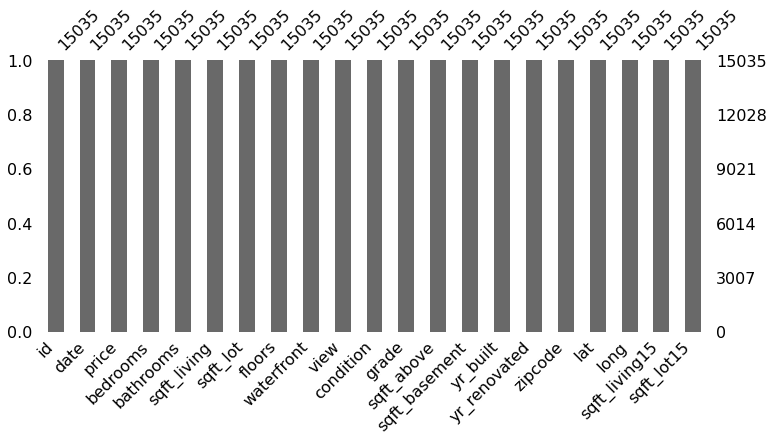

In [146]:
print("Nullity of Train Dataset")
msno.bar(df_train,figsize=(12, 5))      # 결측치 bar형태로 출력
plt.show()

Nullity of Test Dataset


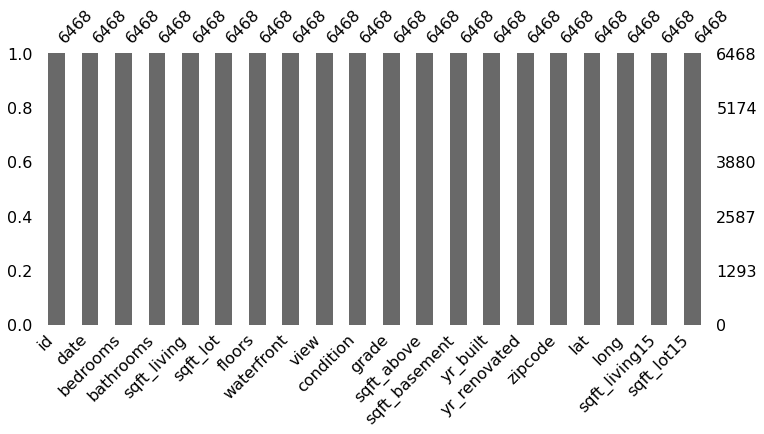

In [147]:
print('Nullity of Test Dataset')
msno.bar(df_test,figsize=(12, 5))        # 결측치 bar형태로 출력
plt.show()

### 이상치 제거
- Train dataset에서 이상치 확인
- Categorical과 Numerical Features 경향성 확인


### Categorical Featuers

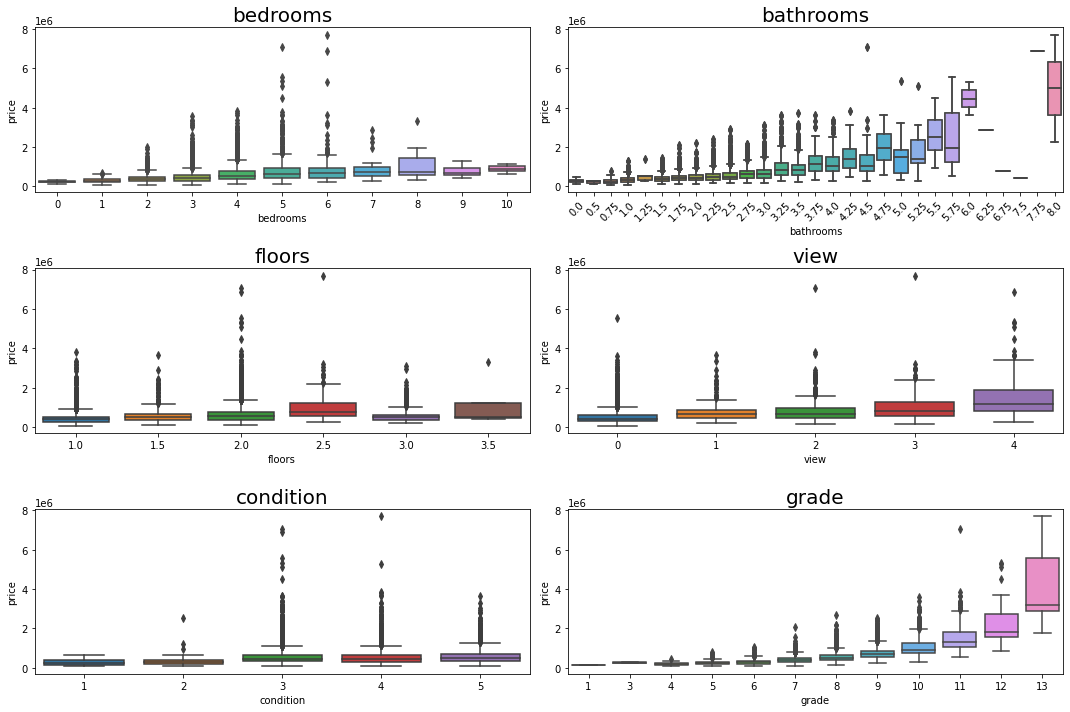

In [148]:
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']

plt.figure(figsize=(15,10))
for  i, feature in enumerate(categorical_features):
    plt.subplot(3,2,i+1)
    if feature == 'bathrooms':
        ax = sns.boxplot(x=feature, y='price', data=df_train)
        plt.setp(ax.get_xticklabels(), rotation=45)   
    sns.boxplot(x=feature, y="price", data=df_train)
    plt.title(feature, fontsize=20)
    
plt.tight_layout()

**Grade 이상치 제거**
- [kaggle 참고](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)

In [326]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

### Numerical Feature
- 이상치라고 생각되는 부분이 없기 때문에 패쓰

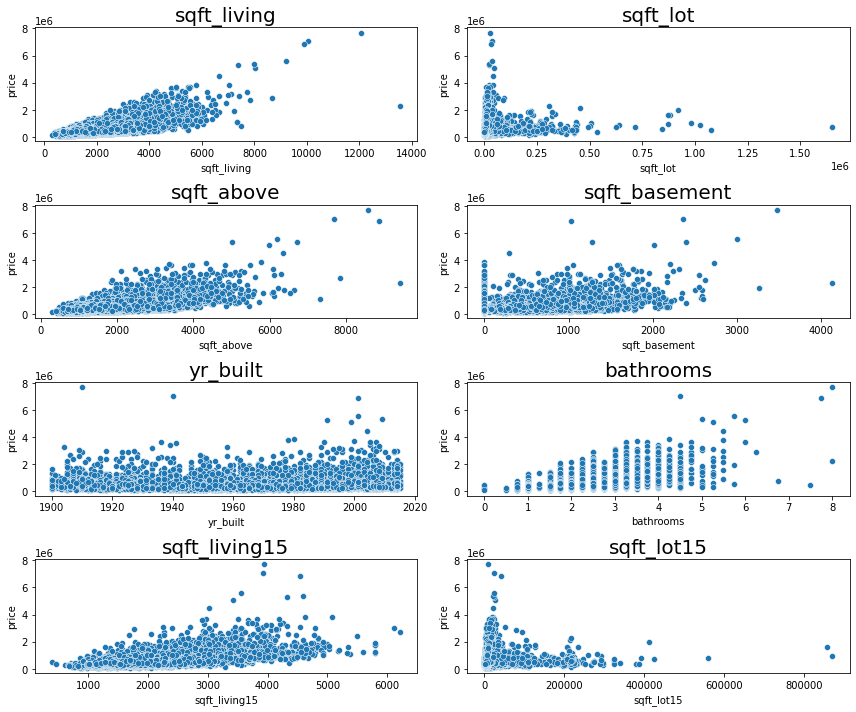

In [149]:
numerical_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                      'yr_built', 'bathrooms', 'sqft_living15', 'sqft_lot15']

plt.figure(figsize=(12,10))
for  i, feature in enumerate(numerical_features):
    plt.subplot(4,2,i+1)
#     if feature == 'bathrooms':
#         ax = sns.scatterplot(x=feature, y='price', data=df_train)
        #plt.setp(ax.get_xticklabels(), rotation=45)   
    sns.scatterplot(x=feature, y="price", data=df_train)
    plt.title(feature, fontsize=20)
    
plt.tight_layout()

### Date와 zip코드 확인
현실적으로 불가능한 수치가 나오는 경우 제외
- Train과 Test 둘 다 해당되는 사항이기 때문에 두 데이터를 합친 후 확인
- date의 경우 Categorical feature로 변환해주기 위해 월,말 부분만 남김
> **확인 결과 문제가 없는 것으로 판단**

<AxesSubplot:xlabel='date', ylabel='zipcode'>

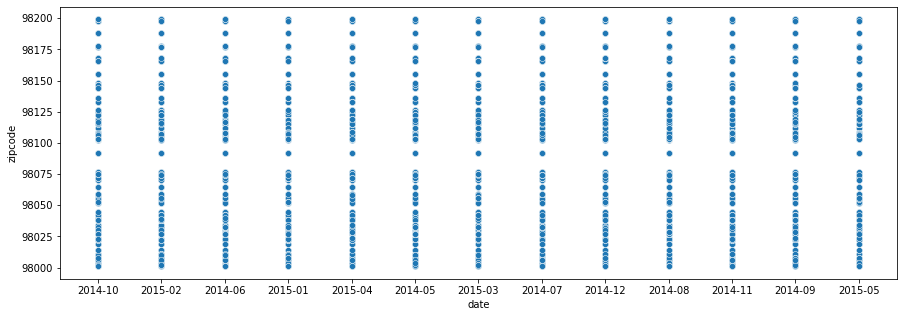

In [150]:
df_merge = pd.concat([df_train[['date', 'zipcode']], df_test[['date', 'zipcode']]])  # train과 test의 date와 zipcode 합치기
df_merge['date'] = pd.to_datetime(df_merge['date']).dt.strftime('%Y-%m')             # date 날짜형식 바꾸기(확인용)

plt.figure(figsize=(15,5))
sns.scatterplot(x='date', y='zipcode', data=df_merge)

# 3. Feature Engineering
Feature들의 특징을 파악하고 정보를 추출
- 예측에 사용하지 않는 feature 제거
- 데이터 편향성 교정
- Feature로부터 유용한 정보 추출
- Price와 연관성이 없어보이는 Feature를 유용한 정보로 활용할 수 있도록 변환
> **각 Feature에 적용해주는 변환은 Train과 Test 모두 동일하게 적용, 따라서 두 Dataset을 합친 후 진행**

### 3-0. Train과 Test 합치기
- price는 Train에만 있으니 제거

In [151]:
train_len = len(df_train)           # 이후에 train부분을 slice하기 위해 index 저장
test_len = len(df_test)             # 이후에 test부분 slice하기 위해 index 저장
df_original = df_train.copy()       # 원본이 필요할  수 있기에 원본 저장

prices = df_train['price']         
prices_log = np.log1p(prices)       # price normalization

del df_train['price']

df_data = pd.concat([df_train, df_test], axis=0)
print('Shape of Data :', df_data.shape)
df_data.head()

Shape of Data : (21503, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 3-1. id열 삭제
id의 경우 단순히 각 데이터의 번호를 부여한 값이기 때문에 삭제

In [152]:
test_id = df_data['id']
del df_data['id']
df_data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 3-2. date 변수 변환
date 변수를 Categorical Feature로 변환해주기 위해 format 변경
- 현재 : 연월일시간(ex. 20141013T000000)
- 변경 : 연월(ex. 201410)
- **Train dataset으로 차이를 확인한 후 전체 적용**
> **일까지 표시된 데이터를 보면 경향성이 보이지 않아 Categorical Feature 변환**

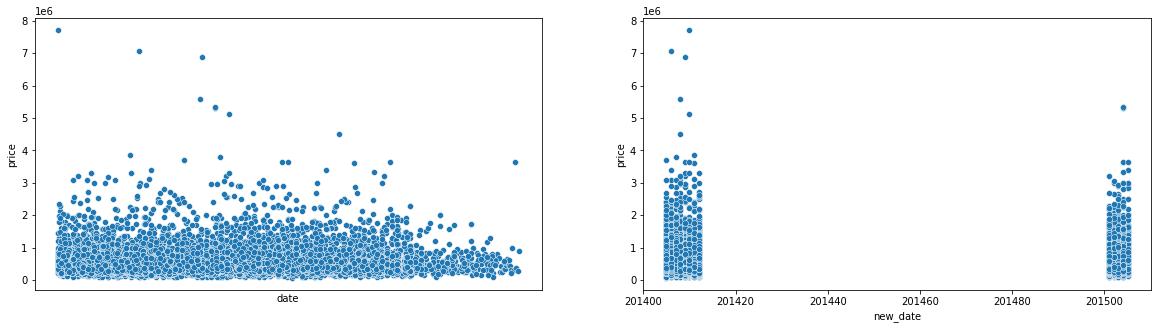

In [153]:
df_example = pd.DataFrame()
df_example['date'] = df_train['date']
df_example['new_date'] = df_train['date'].apply(lambda x: x[0:6]).astype(int)    # 날짜 형식 변경하기 년월일시간 -> 년월 시각화
df_example['price'] = prices

plt.figure(figsize=(20,5))

plt.subplot(1,2,1) 
ax1 = sns.scatterplot(x='date', y='price', data=df_example)
ax1.set_xticks([])

plt.subplot(1,2,2),
ax2 = sns.scatterplot(x='new_date', y='price', data=df_example)

plt.show()

In [154]:
df_data['date'] = df_data['date'].apply(lambda x: x[:6]).astype(int)  # 날짜 형식 변경하기 년월일시간 -> 년월 적용
df_data.head(3)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### 3-4. Numerical Feature의 분포 확인
데이터의 분포를 확인하여 편향되어 있을 경우 Scaling 실시
> **전부 왼쪽으로 편향된 경향이 있기 때문에 전부 Scaling 실시**

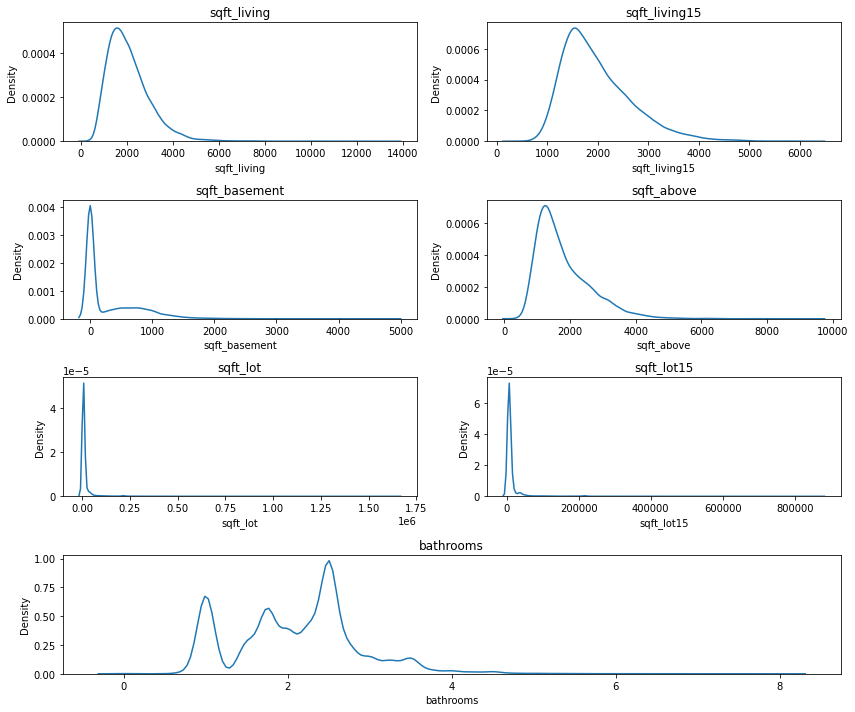

In [155]:
numerical_features = ['sqft_living', 'sqft_living15', 'sqft_basement', 
                      'sqft_above', 'sqft_lot', 'sqft_lot15', 'bathrooms']
ax_list = [421,422,423,424,425,426,414]

plt.figure(figsize=(12,10))
for i, feature in zip(ax_list, numerical_features):
    plt.subplot(i)
    plt.title(feature)
    sns.kdeplot(df_data[feature])  # 커널밀도함수 출력(히스토그램 업그레이드 버젼)
    
plt.tight_layout()

In [156]:
# 편향이 일어난 columns
skew_features = ['sqft_living', 'sqft_living15', 'sqft_basement', 
                'sqft_above', 'sqft_lot', 'sqft_lot15', 'bathrooms']

# 편향이 일어난 columns의 값들에 log값 적용
for feature in skew_features:
    df_data[feature] = np.log1p(df_data[feature].values)
print("Apply Log(x) Function")

Apply Log(x) Function


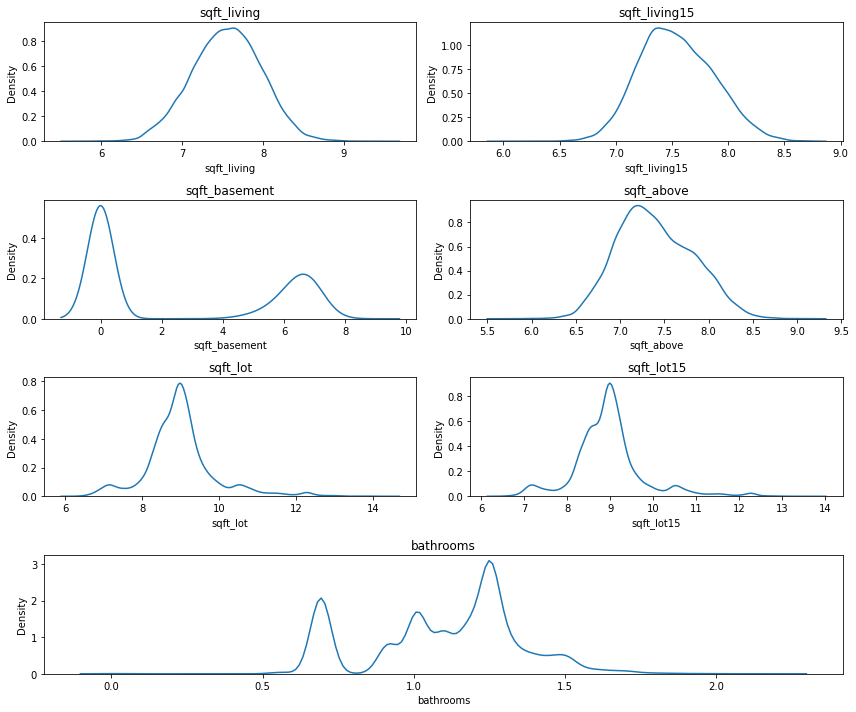

In [157]:
# log값 적용한 후에 시각화
numerical_features = ['sqft_living', 'sqft_living15', 'sqft_basement', 
                      'sqft_above', 'sqft_lot', 'sqft_lot15', 'bathrooms']

plt.figure(figsize=(12,10))
ax_list = [421,422,423,424,425,426,414]
for i, feature in zip(ax_list, numerical_features):
    plt.subplot(i)
    plt.title(feature)
    sns.kdeplot(df_data[feature])
    
plt.tight_layout()

### 3.5 Lot Lat 데이터 변형
- Lot Lat 데이터를 이용해 각 데이터의 지역 이름을 추가
- **Shapefile과 공간분석 라이브러리 Geopandas를 이용해 변환**

### Shapefile 특징
- Columns의 가장 오른쪽에 Geometry형식의 Polygon으로 공간분석 가능
- 실제 좌표계(crs=4326)를 이용해 각 집들의 point와 미국 지도를 intersection

In [305]:
import geopandas as gpd

df_train_example = df_data[:train_len]                       
shapefile_dir = os.getenv('HOME') + '/aiffel/shapfile'
USA = gpd.read_file(os.path.join(shapefile_dir, 'tl_2016_53_cousub.shp')) # Shapefile 불러오기
USA.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,53,003,90096,01939443,5300390096,Asotin,Asotin CCD,22,Z5,G4040,None,None,None,S,1340244511,8191372,+46.1474746,-117.1964025,"POLYGON ((-117.47997 46.01631, -117.47991 46.0..."
1,53,003,90592,01939474,5300390592,Clarkston,Clarkston CCD,22,Z5,G4040,None,None,None,S,307199433,3084334,+46.3442652,-117.3012796,"POLYGON ((-117.42077 46.33866, -117.42073 46.3..."
2,53,075,90656,01939478,5307590656,Colfax-Palouse,Colfax-Palouse CCD,22,Z5,G4040,None,None,None,S,608990251,10534,+46.8961192,-117.2915620,"POLYGON ((-117.58929 46.86652, -117.58926 46.8..."
3,53,075,91552,01939535,5307591552,LaCrosse,LaCrosse CCD,22,Z5,G4040,None,None,None,S,1318314850,24179160,+46.7282243,-117.8212524,"POLYGON ((-118.24934 46.73384, -118.24912 46.7..."
4,53,075,92832,01939615,5307592832,Rock Lake,Rock Lake CCD,22,Z5,G4040,None,None,None,S,1577017631,11603165,+47.0541435,-117.7254566,"POLYGON ((-118.00506 46.84360, -118.00498 46.8..."


<AxesSubplot:>

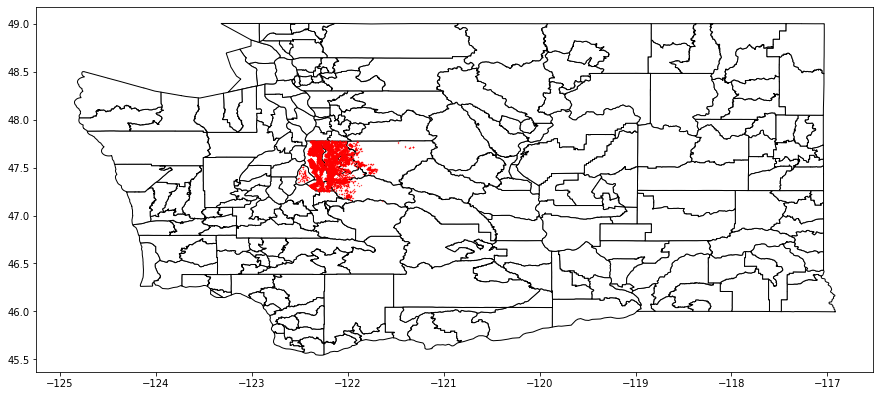

In [306]:
# 단순히 실수값인 Lat, Long 데이터를 Geometry형으로 변환
data_point = gpd.GeoDataFrame(df_train_example, geometry=gpd.points_from_xy(df_train_example.long, df_train_example.lat))
base_map = USA.plot(color='white', edgecolor='black', figsize=(15,15))     # 미국 지도
data_point.plot(ax=base_map, marker='o', color='red', markersize=0.1)      # 집 위치

<AxesSubplot:>

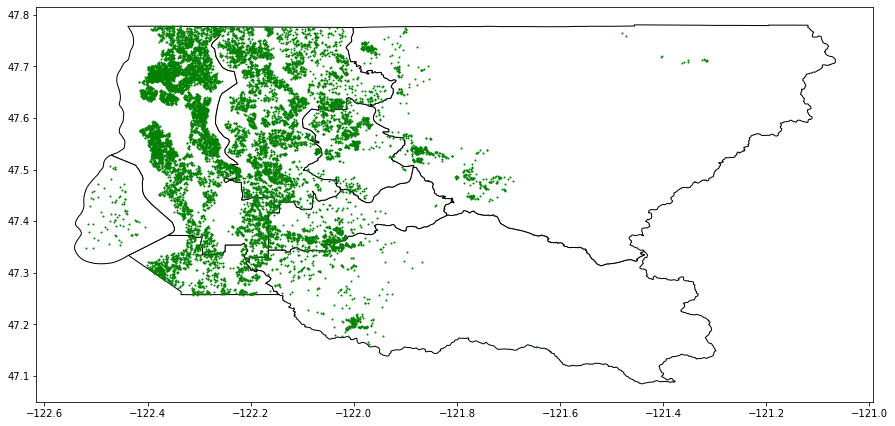

In [307]:
cities = USA[USA.intersects(data_point.unary_union)]                         # 각 점들이 위치해있는 도시 출력(Intersection)
base_map1 = cities.plot(color='white', edgecolor='black', figsize=(15,15))   # 점들이 위치해있는 지도 시각화
data_point.plot(ax=base_map1, color='g', markersize=1)                       # 지도 위에 각 집 위치 표시

In [308]:
# 각 집들이 어느 도시에 속하는지 새로운 column에 추가
city = []
for i in range(len(data_point)):                                                     # 각 집(point)를 하나씩 불러오고
    for j in range(len(cities)):                                                     # 각 도시들을 하나씩 불러와
        intersected = data_point.iloc[i].geometry.intersects(cities.iloc[j].geometry) # 두 geometry를 intersect 
        if intersected:                                                               # 각 집이 위치해잇는 도시 index 추출
            city.append(cities['NAME'].iloc[j])                                       # 도시를 index로 불러와 list에 추가(집 순서대로)
            
# 맨 오른쪽 city 컬럼 추가
data_point['city'] = city
data_point.head(3)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,city_Enumclaw Plateau,city_Federal Way-Auburn,city_Issaquah Plateau,city_Seattle,city_Seattle East,city_Snoqualmie Valley,city_Tahoma-Maple Valley,city_Vashon Island,geometry,city
0,201410,3,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,0,0,0,1,0,0,0,0,POINT (-122.25700 47.51120),Seattle
1,201502,2,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,0,0,0,0,1,0,0,0,POINT (-122.23300 47.73790),Seattle East
2,201502,3,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,0,0,0,0,1,0,0,0,POINT (-122.04500 47.61680),Seattle East


### String Categorical 형인 city값들을 숫자로 encoding

In [330]:
# one-hot encoding 방식
pd.get_dummies(df_data, columns=["city"]).head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,city_Tahoma-Maple Valley,city_Vashon Island,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7
0,201410,3,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,0,0,0,0,0,1,0,0,0,0
1,201502,2,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,0,0,0,0,0,0,1,0,0,0
2,201502,3,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,0,0,0,0,0,0,1,0,0,0
3,201406,3,1.178655,7.447751,8.827615,2.0,0,0,3,7,...,0,0,0,1,0,0,0,0,0,0
4,201501,3,0.916291,6.966967,9.181118,1.0,0,0,3,7,...,0,0,0,0,0,1,0,0,0,0


In [311]:
# Categorical encoding 방식
df_data = data_point.drop(['geometry'], axis=1)
df_data['city'] = df_data["city"].astype('category')
df_data["city"] = df_data["city"].cat.codes
df_data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,city_Enumclaw Plateau,city_Federal Way-Auburn,city_Issaquah Plateau,city_Seattle,city_Seattle East,city_Snoqualmie Valley,city_Tahoma-Maple Valley,city_Vashon Island,city
0,201410,3,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,8.639588,0,0,0,1,0,0,0,0,3
1,201502,2,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,8.995041,0,0,0,0,1,0,0,0,4
2,201502,3,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,8.923191,0,0,0,0,1,0,0,0,4
3,201406,3,1.178655,7.447751,8.827615,2.0,0,0,3,7,...,8.827615,0,1,0,0,0,0,0,0,1
4,201501,3,0.916291,6.966967,9.181118,1.0,0,0,3,7,...,9.181118,0,0,0,1,0,0,0,0,3


# 4. 모델링
위에서 추출한 Features를 이용해 모델을 학습

### 데이터 준비

In [312]:
x_train = df_data.iloc[:train_len]          # 입력값 x
y_train = prices                            # 출력값(Price)
x_test = df_data.iloc[train_len:]           # 테스트 데이터(제출용)

df_RMSE_result = {'model' : [], 'RMSE' : []}

### Xgboost 시도

In [313]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# xgboost의 하이퍼파라미터
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(x_train, y_train)  # xgboost가 학습할 수 있는 형태의 dataset으로 변경
dtest = xgb.DMatrix(x_test)             # xgboost가 학습할 수 있는 형태의 dataset으로 변경

print('Start Cross Validation...')

# Cross Validation 실시
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20, verbose_eval=50)

Transform DMatrix...
Start Cross Validation...


Best num_boost_rounds =  3150
Best Score of RMSE =  117580.50781233334


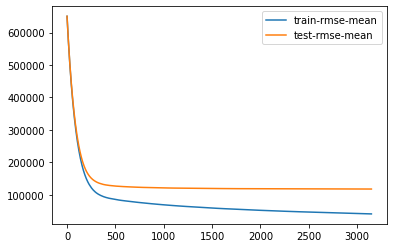

In [314]:
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
rounds = len(cv_output)
print('Best num_boost_rounds = ', len(cv_output))
print('Best Score of RMSE = ', cv_output.loc[rounds-1, 'test-rmse-mean'])

df_RMSE_result['model'].append('Xgboost') 
df_RMSE_result['RMSE'].append(cv_output.loc[rounds-1, 'test-rmse-mean'])

### LightGBM

In [316]:
# LgihtGBM 하이퍼 파라미터
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

x_train = df_data.iloc[:train_len]
y_train = prices
x_test = df_data.iloc[train_len:]

y_reg = np.log1p(prices)

train_columns = list(x_train.columns)

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)    # KFold Cross Validation 함수
oof = np.zeros(len(x_train))
#predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()                       # 이후에 feature의 중요도를 시각화하기 위한 준비단계

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx]) # LightGBM이 학습할 수 있는 형식으로 변환
    val_data = lgb.Dataset(x_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx]) # LightGBM이 학습할 수 있는 형식으로 변환

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.141495	valid_1's rmse: 0.167059
[1000]	training's rmse: 0.124023	valid_1's rmse: 0.162541
[1500]	training's rmse: 0.11252	valid_1's rmse: 0.161134
[2000]	training's rmse: 0.103376	valid_1's rmse: 0.160675
Early stopping, best iteration is:
[2339]	training's rmse: 0.0979421	valid_1's rmse: 0.160438
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.140796	valid_1's rmse: 0.164955
[1000]	training's rmse: 0.123213	valid_1's rmse: 0.160786
[1500]	training's rmse: 0.111971	valid_1's rmse: 0.15975
Early stopping, best iteration is:
[1686]	training's rmse: 0.108429	valid_1's rmse: 0.159566
[LightGBM] [Warning] min_data_in_leaf is se

In [317]:
cv = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv)

df_RMSE_result['model'].append('LightGBM') 
df_RMSE_result['RMSE'].append(cv)

118620.28991697697


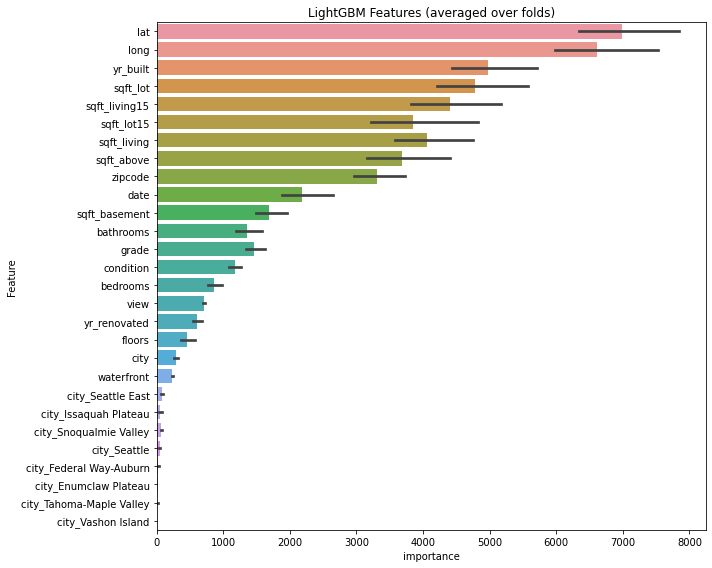

In [318]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [320]:
model = LGBMRegressor(objective='regression', num_iterations=10**5)
x_data = x_train
y_data = np.log1p(prices)
X_train, X_val, Y_train, Y_val = train_test_split(x_data, y_data, random_state=0)
model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(X_val)
score = np.sqrt(mean_squared_error(np.expm1(val_pred), np.expm1(Y_val)))


df_RMSE_result['model'].append('LGBMRegressor') 
df_RMSE_result['RMSE'].append(score)
score

112129.93877303714

# RMSE 결과 모음
#### Geometry 정보를 입력하기 전 결과

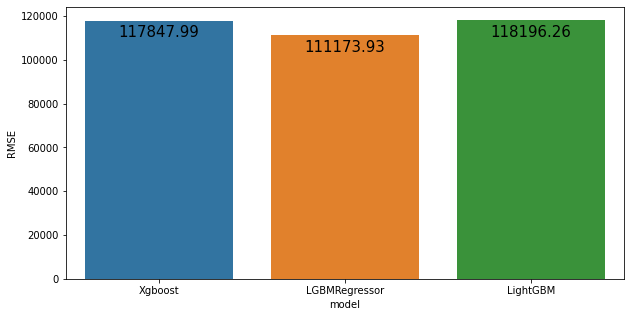

In [291]:
plt.figure(figsize=(10,5))

splot = sns.barplot(x='model', y='RMSE', data=pd.DataFrame(df_RMSE_result))
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

#### geometry 정보를 입력한 후 결과
- City를 one-hot-encoding으로 입력했을 때 결과
- ex) A도시 = (1,0,0,0) / B도시 = (0,1,0,0) / C도시 = (0,0,1,0) / D도시 = (0,0,0,1)

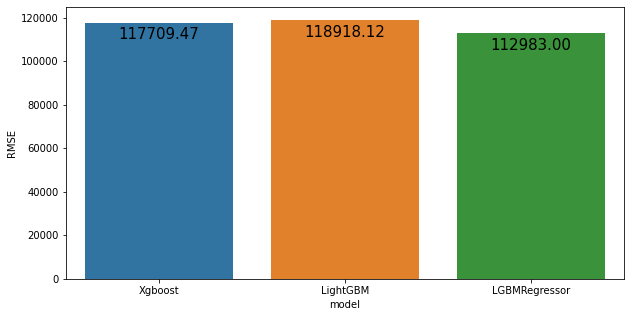

In [304]:
plt.figure(figsize=(10,5))

splot = sns.barplot(x='model', y='RMSE', data=pd.DataFrame(df_RMSE_result))
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

#### geometry 정보를 입력한 후 결과
- City를 Categorical encoding으로 입력했을 때 결과
- ex) A도시 = 0 / B도시 = 1 / C도시 = 2 / D도시 = 3 

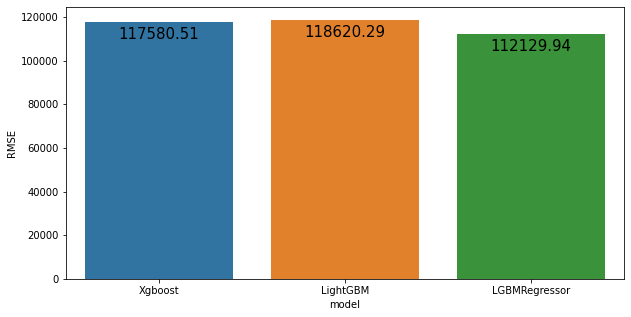

In [321]:
plt.figure(figsize=(10,5))

splot = sns.barplot(x='model', y='RMSE', data=pd.DataFrame(df_RMSE_result))
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

# 결과 및 고찰
- 우선 11만 이하로 내리지는 못 했지만, 최대한 비슷한 값이 나온 것 같다.
- Lat과 Long을 다른 형태로 변환했지만 딱히 큰 이득을 보진 않았다.
- 도시 이름을 one-hot encoding한 것 보다는 Categorical encoding을 한 것이 더 효과적이다.
- 정말 다양한 분석기법이 있다는 것을 배웠고, 각 모델들을 하나씩 이해하면서 사용해야겠다는 생각을 했다.
- Feature Engineering의 중요성을 깨달았다.
> **Kaggle은 데이터 분석을 위한 가장 좋은 플랫폼이라고 생각한다.**